In [1]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Exploring data

In [463]:
dataPath = 'nlp-getting-started/train.csv'
data = pd.read_csv(dataPath, index_col=0)

In [464]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


### Count

In [101]:
data.count()

keyword     7552
location    5080
text        7613
target      7613
dtype: int64

### Nan

In [102]:
data.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [103]:
dataNonNull = data.dropna()

In [104]:
print(f'{"Columns":20}: {"All":10} {"NonNull":10} {"%NonNull":10} {"Difference"}')
for idx, col in enumerate(data.columns):
    allValue = data.count()[idx]
    nonNullValue = dataNonNull.count()[idx]
    per = nonNullValue*100/allValue
    diff = allValue - nonNullValue
    print(f'{col:20}: {allValue} {nonNullValue:10} {np.round(per):10} {diff:10}')

Columns             : All        NonNull    %NonNull   Difference
keyword             : 7552       5080       67.0       2472
location            : 5080       5080      100.0          0
text                : 7613       5080       67.0       2533
target              : 7613       5080       67.0       2533


In [105]:
data['keyword'].fillna("", inplace=True)
data['location'].fillna("", inplace=True)

## Target

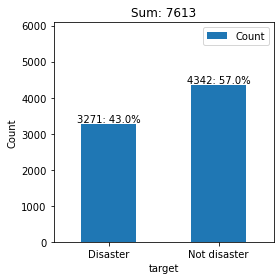

In [106]:
columnName = 'target'

#----------------------
def getCategoricalColumn(value):
    if value == 1: return "Disaster"
    else: return "Not disaster"
    
CategoricalColumn = data[columnName].apply(getCategoricalColumn)
CategoricalColumn.name = 'catTarget'

df = pd.concat([data, CategoricalColumn], axis=1)
#----------------------

groups = []
for group, subset in df.groupby(by=CategoricalColumn.name):
    groups.append({
        CategoricalColumn.name: group,
        'Count': len(subset)
    })

lenData = data[columnName].count()

dataCategoricalQuality = pd.DataFrame(groups)

fig, ax = plt.subplots(figsize=(4, 4))

dataCategoricalQuality.plot.bar(x=CategoricalColumn.name, ax=ax)

for i in range(len(groups)):
    value = str(groups[i]['Count'])+': '+str(np.round(groups[i]['Count']*100/lenData))+'%'
    ax.text(i, groups[i]['Count'], value , horizontalalignment='center', 
            verticalalignment='bottom')

ax.set_ylim(0, lenData - lenData/5)

ax.set_xlabel('target')
ax.set_ylabel('Count')
ax.set_title('Sum: '+ str(lenData) )
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### target vs keyword

In [ ]:
data['keyword'] = data['keyword'].str.replace('%20', ' ')

In [ ]:
columnNameA = 'target'
columnNameB = 'keyword'

crossTable = pd.crosstab(index=data[columnNameB],
                         columns=data[columnNameA],
                         margins=True)

crossTable.rename(columns={0 : 'Not disaster',1 : 'Disaster',}, inplace=True)

In [ ]:
print('Most frequent Keywords for Disaster')
crossTable.sort_values(by='Disaster', ascending=False).head(10)

In [ ]:
print('Most frequent Keywords for Not disaster')
crossTable.sort_values(by='Not disaster', ascending=False).head(10)

#### target vs keyword length (character)

In [ ]:
data['keywordLengthChar'] = data['keyword'].apply(len)

In [ ]:
columnNameA = 'target'
columnNameB = 'keywordLengthChar'

sns.boxplot(data=data, x=columnNameA, y=columnNameB)


plt.tight_layout()
plt.show()

In [ ]:
columnNameA = 'target'
columnNameB = 'keywordLengthChar'

g = sns.FacetGrid(data, col=columnNameA)
g.map(sns.histplot, columnNameB, bins=30)

plt.tight_layout()
plt.show()

We observe that keyword lengths are longer in Not Disaster than in Disaster

### target vs location

In [ ]:
columnNameA = 'target'
columnNameB = 'location'

crossTable = pd.crosstab(index=data[columnNameB],
                         columns=data[columnNameA],
                         margins=True)

crossTable.rename(columns={0 : 'Not disaster',1 : 'Disaster',}, inplace=True)

In [ ]:
print('Most frequent Locations for Disaster')
crossTable.sort_values(by='Disaster', ascending=False).head(10)

In [ ]:
print('Most frequent Locations for Not disaster')
crossTable.sort_values(by='Not disaster', ascending=False).head(10)

### target vs text

#### Number of character (including space)

In [ ]:
data['textLengthChar'] = data['text'].apply(len)

In [ ]:
columnName = 'textLengthChar'

ax = (data[columnName]).plot.box(figsize=(3, 4))
ax.set_ylabel(columnName)

plt.tight_layout()
plt.show()

In [ ]:
columnNameA = 'target'
columnNameB = 'textLengthChar'

g = sns.FacetGrid(data, col=columnNameA)
g.map(sns.histplot, columnNameB, bins=30)

plt.tight_layout()
plt.show()

We observe that text lengths are longer in Not Disaster than in Disaster

In [ ]:
columnNameA = 'target'
columnNameB = 'textLengthChar'

sns.boxplot(data=data, x=columnNameA, y=columnNameB)

plt.tight_layout()
plt.show()

#### Number of words

In [ ]:
def getWordTextLength(text):
    return len(text.split())
data['textLengthWord'] = data['text'].apply(getWordTextLength)

In [ ]:
columnName = 'textLengthWord'

ax = (data[columnName]).plot.box(figsize=(3, 4))
ax.set_ylabel(columnName)

plt.tight_layout()
plt.show()

In [ ]:
columnNameA = 'target'
columnNameB = 'textLengthWord'

g = sns.FacetGrid(data, col=columnNameA)
g.map(sns.histplot, columnNameB, bins=30)

plt.tight_layout()
plt.show()

We observe that number of words in text are longer in Not Disaster than in Disaster

In [ ]:
columnNameA = 'target'
columnNameB = 'textLengthWord'

sns.boxplot(data=data, x=columnNameA, y=columnNameB)

plt.tight_layout()
plt.show()

#### Link in text

In [ ]:
pattern = r'(https?://\S+)'
data['link']= data["text"].str.extract(pattern)
    
data['containLink'] = data['link'].notna()

In [ ]:
columnNameA = 'target'
columnNameB = 'containLink'

crossTable = pd.crosstab(index=data[columnNameB],
                         columns=data[columnNameA],
                         margins=True)

crossTable.rename(columns={0 : 'Not disaster',1 : 'Disaster',}, inplace=True)
crossTable.rename(index={False : 'No link',True : 'Link',}, inplace=True)

crossTable['Not disaster %'] = crossTable['Not disaster'] * 100 / crossTable['All']
crossTable['Disaster %'] = crossTable['Disaster'] * 100 / crossTable['All']

crossTable

We observe that there are more links in Disaster than Not Disaster.

# Processing data using PyPark

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

sc = SparkContext(master = "local", appName = "App").getOrCreate()
spark = SparkSession.builder.getOrCreate()

print(sc, sc.version, spark)

<SparkContext master=local appName=App> 3.2.0 <pyspark.sql.session.SparkSession object at 0x7f9b7f6116d0>


## Loading data

In [3]:
spark.catalog.listTables()

[]

### Training set

In [4]:
trainPath = 'nlp-getting-started/train.csv'
trainData = spark.read.format('csv').options(header='true', inferSchema='true', multiLine=True).load(trainPath)
trainData.printSchema()

root
 |-- id: integer (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



In [5]:
print('Number of row:', trainData.count())
trainData.show(5)

Number of row: 7613
+---+-------+--------+--------------------+------+
| id|keyword|location|                text|target|
+---+-------+--------+--------------------+------+
|  1|   null|    null|Our Deeds are the...|     1|
|  4|   null|    null|Forest fire near ...|     1|
|  5|   null|    null|All residents ask...|     1|
|  6|   null|    null|13,000 people rec...|     1|
|  7|   null|    null|Just got sent thi...|     1|
+---+-------+--------+--------------------+------+
only showing top 5 rows



In [6]:
trainData.createOrReplaceTempView('trainData')

### Test set

In [7]:
testPath = 'nlp-getting-started/test.csv'
testData = spark.read.format('csv').options(header='true', inferSchema='true', multiLine=True).load(testPath)
testData.printSchema()

root
 |-- id: integer (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)



In [8]:
print('Number of row:', testData.count())
testData.show(5)

Number of row: 3263
+---+-------+--------+--------------------+
| id|keyword|location|                text|
+---+-------+--------+--------------------+
|  0|   null|    null|Just happened a t...|
|  2|   null|    null|Heard about #eart...|
|  3|   null|    null|there is a forest...|
|  9|   null|    null|Apocalypse lighti...|
| 11|   null|    null|Typhoon Soudelor ...|
+---+-------+--------+--------------------+
only showing top 5 rows



In [9]:
testData.createOrReplaceTempView('testData')

## Preprocessing

### Preprocessing step by step

In [11]:
dataframe = spark.sql("SELECT * FROM trainData WHERE target is not NULL")
dataframe.count()

7176

#### Preprocessing Nan

In [ ]:
dataframe = dataframe.na.fill(value="",subset=["keyword", "location", "text"])

#### Preprocessing text

In [ ]:
import pyspark.sql.functions as F

In [ ]:
textColector = dataframe.collect()
for line in textColector[:5]:
    print(line['text'])

Create column checking if there is a link

In [ ]:
from pyspark.sql.types import IntegerType

pattern = r'(https?://\S+)'

dataframe = dataframe.withColumn("containLink", F.when(F.col("text").rlike(pattern),1).otherwise(0))

Create column without link

In [ ]:
pattern = r'(https?://\S+)'

dataframe = dataframe.withColumn('textNoLink', F.regexp_replace(F.col('text'), pattern, ""))

Tokenizer: list of words and removing special characters

In [ ]:
from pyspark.ml.feature import RegexTokenizer

dataframe = dataframe.drop('wordText')
dataframe = RegexTokenizer(inputCol="textNoLink", outputCol="wordText", pattern="\\W").transform(dataframe)

In [ ]:
from pyspark.ml.feature import StopWordsRemover

locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

dataframe = dataframe.drop('wordTextNoSW')
dataframe= StopWordsRemover(inputCol="wordText", outputCol="wordTextNoSW").transform(dataframe)

In [ ]:
from pyspark.ml.feature import Word2Vec

dataframe = dataframe.drop('vecText')
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="wordTextNoSW", outputCol="vecText")
dataframe = word2Vec.fit(dataframe).transform(dataframe)

#### Preprocessing keyword and location

In [ ]:
from pyspark.ml import Pipeline 
from pyspark.ml.feature import StringIndexer

# For mulitple columns
dataframe = dataframe.drop('keywordIndex')
dataframe = dataframe.drop('locationIndex')
indexers = [StringIndexer(inputCol=column, outputCol=column+"Index")\
            for column in list(set(["keyword", "location"])) ]

pipeline = Pipeline(stages=indexers)

dataframe = pipeline.fit(dataframe).transform(dataframe)

#### Create several features based on length

In [ ]:
dataframe = dataframe.withColumn('keywordLength', F.length('keyword'))

In [ ]:
dataframe = dataframe.withColumn('textNoLinkLength', F.length('textNoLink'))

#### Feature assembler

In [ ]:
from pyspark.ml.feature import VectorAssembler

dataframe = dataframe.drop('catFeatures')
catAssembler = VectorAssembler(inputCols=["keywordIndex", "locationIndex", 
                                        "keywordLength", "textNoLinkLength",
                                        "containLink"], outputCol="catFeatures")

dataframe = catAssembler.transform(dataframe)

In [ ]:
dataframe = dataframe.drop('catTextFeatures')
catTextAssembler = VectorAssembler(inputCols=["keywordIndex", "locationIndex", 
                                        "keywordLength", "textNoLinkLength",
                                        "containLink", "vecText"], outputCol="catTextFeatures")

dataframe = catTextAssembler.transform(dataframe)

#### Feature normalization

In [ ]:
from pyspark.ml.feature import RobustScaler

dataframe = dataframe.drop('catFeaturesRobustScaler')
catFeatureRobustScaler = RobustScaler(inputCol="catFeatures", outputCol="catFeaturesRobustScaler",
                                      withScaling=True, withCentering=True,
                                      lower=0.25, upper=0.75)

dataframe = catFeatureRobustScaler.fit(dataframe).transform(dataframe)

In [ ]:
dataframe = dataframe.drop('catTextFeaturesRobustScaler')
catTextFeatureRobustScaler = RobustScaler(inputCol="catTextFeatures", outputCol="catTextFeaturesRobustScaler",
                                      withScaling=True, withCentering=True,
                                      lower=0.25, upper=0.75)

dataframe = catTextFeatureRobustScaler.fit(dataframe).transform(dataframe)

### Preprocessing pipeline

In [10]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml import Pipeline 
import pyspark.sql.functions as F
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Word2Vec, StringIndexer, VectorAssembler, RobustScaler

In [11]:
class FillNanTransformer(Transformer, HasInputCol):
    @keyword_only
    def __init__(self, inputCol=None):
        super(FillNanTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, dataset):
        dataset = dataset.na.fill(value="",subset=[self.getInputCol()])
        return dataset
    
class TextNoLinkTransformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(TextNoLinkTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, dataset):
        pattern = r'(https?://\S+)'
        dataset = dataset.withColumn(self.getOutputCol(), F.regexp_replace(F.col(self.getInputCol()), pattern, ""))
        return dataset
    
class ContainLinkTransformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(ContainLinkTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, dataset):
        pattern = r'(https?://\S+)'
        dataset = dataset.withColumn(self.getOutputCol(), F.when(F.col(self.getInputCol()).rlike(pattern),1).otherwise(0))
        return dataset
    
class KeywordLengthTransformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(KeywordLengthTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, dataset):
        dataset = dataset.withColumn(self.getOutputCol(), F.length(self.getInputCol()))
        return dataset
    
class TextNoLinkLengthTransformer(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(TextNoLinkLengthTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, dataset):
        dataset = dataset.withColumn(self.getOutputCol(), F.length(self.getInputCol()))
        return dataset

In [163]:
textFillNanTransformer = FillNanTransformer(inputCol="text")
keywordFillNanTransformer = FillNanTransformer(inputCol="keyword")
locationFillNanTransformer = FillNanTransformer(inputCol="location")

containLinkTransformer = ContainLinkTransformer(inputCol="text", outputCol="containLink")
textNoLinkTransformer = TextNoLinkTransformer(inputCol="text", outputCol="textNoLink")

regexTokenizer = RegexTokenizer(inputCol="textNoLink", outputCol="wordText", pattern="\\W")
stopWordsRemover = StopWordsRemover(inputCol="wordText", outputCol="wordTextNoSW")
word2Vec = Word2Vec(vectorSize=50, windowSize=10, minCount=0, inputCol="wordTextNoSW", outputCol="vecText")
keywordIndexer = StringIndexer(inputCol="keyword", outputCol="keywordIndex", handleInvalid="keep")
locationIndexer = StringIndexer(inputCol="location", outputCol="locationIndex", handleInvalid="keep")

keywordLengthTransformer = KeywordLengthTransformer(inputCol="keyword", outputCol="keywordLength")
textNoLinkLengthTransformer = TextNoLinkLengthTransformer(inputCol="textNoLink", outputCol="textNoLinkLength")

catAssembler = VectorAssembler(inputCols=["keywordIndex", "locationIndex", 
                                        "keywordLength", "textNoLinkLength",
                                        "containLink"], outputCol="catFeatures")

catTextAssembler = VectorAssembler(inputCols=["keywordIndex", "locationIndex", 
                                        "keywordLength", "textNoLinkLength",
                                        "containLink", "vecText"], outputCol="catTextFeatures")

catFeatureRobustScaler = RobustScaler(inputCol="catFeatures", outputCol="catFeaturesRobustScaler",
                                      withScaling=True, withCentering=True,
                                      lower=0.25, upper=0.75)

catTextFeatureRobustScaler = RobustScaler(inputCol="catTextFeatures", outputCol="catTextFeaturesRobustScaler",
                                      withScaling=True, withCentering=True,
                                      lower=0.25, upper=0.75)

In [165]:
preprocessingPipeline = Pipeline(stages=[textFillNanTransformer,
                                keywordFillNanTransformer,
                                locationFillNanTransformer,
                                containLinkTransformer,
                                textNoLinkTransformer,
                                regexTokenizer,
                                stopWordsRemover,
                                word2Vec,
                                keywordIndexer,
                                locationIndexer,
                                keywordLengthTransformer,
                                textNoLinkLengthTransformer,
                                catAssembler,
                                catTextAssembler,
                                catFeatureRobustScaler,
                                catTextFeatureRobustScaler
                                    ])

## Training

In [169]:
trainingData = spark.sql("SELECT * FROM trainData")  
testData = spark.sql("SELECT * FROM testData")

In [170]:
trainingDataPreprocessed = preprocessingPipeline.fit(trainingData).transform(trainingData)
testDataPreprocessed = preprocessingPipeline.fit(trainingData).transform(testData)

In [171]:
trainSet, validSet = trainingDataPreprocessed.randomSplit([0.9, 0.1], seed=12345)

In [172]:
featuresCol = "catTextFeaturesRobustScaler"
labelCol = "target"

### Several algorithms

In [188]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier, LinearSVC

evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, predictionCol="prediction", metricName="f1")

algorithmList = {"LR":   LogisticRegression(featuresCol=featuresCol, labelCol=labelCol,regParam = 0.1, maxIter=50),
                 "DTC":  DecisionTreeClassifier(featuresCol=featuresCol, labelCol=labelCol, maxDepth=5),
                 "RFC":  RandomForestClassifier(featuresCol=featuresCol, labelCol=labelCol, maxDepth=5, numTrees=20),
                 "GBTC": GBTClassifier(featuresCol=featuresCol, labelCol=labelCol, maxIter=50, maxDepth=5, stepSize=0.1),
                 "MPC":  MultilayerPerceptronClassifier(featuresCol=featuresCol, labelCol=labelCol, maxIter=50, layers=[55, 5, 2]),
                 "LSVC": LinearSVC(featuresCol=featuresCol, labelCol=labelCol, maxIter=50, regParam=0.01)
                }

We observe predictions of validation set based on several feature sets:
* "catFeaturesRobustScaler": "keywordIndex", "locationIndex", "keywordLength", "textNoLinkLength", "containLink"
* "catTextFeaturesRobustScaler": "catFeaturesRobustScaler" and "vecText"
* "vecText" only

In [125]:
featuresCols = ["catFeaturesRobustScaler", "catTextFeaturesRobustScaler", "vecText"]
algorithmName = "LR"
for param in featuresCols:
    startTime = time.time()
    algorithm = algorithmList[algorithmName].setFeaturesCol(param)
    prediction = algorithm.fit(trainSet).transform(validSet)
    score = evaluator.evaluate(prediction)
    print(f'Param {param}: {np.round(score,5)} in {np.round(time.time() - startTime, 3)}s')

Param catFeaturesRobustScaler: 0.6181 in 2.617s
Param catTextFeaturesRobustScaler: 0.67661 in 2.892s
Param vecText: 0.64727 in 2.617s


In [189]:
algorithmName = "MPC"
algorithm = algorithmList[algorithmName]
prediction = algorithm.fit(trainSet).transform(validSet)
score = evaluator.evaluate(prediction)
print(score)

0.726434679392731


### Other algorithms

#### Write data

In [182]:
from os import walk
import re

def getCSVFromPysparkPath(path):
    filenames = next(walk(path), (None, None, []))[2]
    for filename in filenames:
        if re.search('^part', filename):
            return path+'/'+filename

In [183]:
from pyspark.ml.functions import vector_to_array

(trainSet.withColumn("feature", vector_to_array("catTextFeaturesRobustScaler")))\
.select(["target"]+ [F.col("feature")[i] for i in range(55)]).write.mode('overwrite').csv('trainCSV')

(validSet.withColumn("feature", vector_to_array("catTextFeaturesRobustScaler")))\
.select([F.col("feature")[i] for i in range(55)]).write.mode('overwrite').csv('validCSV')

trainPath = getCSVFromPysparkPath("trainCSV")
validPath = getCSVFromPysparkPath("validCSV")

In [184]:
(testDataPreprocessed.withColumn("feature", vector_to_array("catTextFeaturesRobustScaler")))\
.select([F.col("feature")[i] for i in range(55)]).write.mode('overwrite').csv('testCSV')

testPath = getCSVFromPysparkPath("testCSV")

#### Lightgbm

In [177]:
import lightgbm as lgb

In [178]:
trainSetLgb = lgb.Dataset(trainPath)
#validSetLgb = lgb.Dataset(validPath, reference=trainSetLgb)

In [190]:
param = {'max_depth': 5, 
         'objective': 'binary',
         'metric': 'auc',
         'learning_rate': 0.1,
         'num_iterations': 500,
         'boosting': 'dart'
        }

In [191]:
bst = lgb.train(param, trainSetLgb)

In [ ]:
predProbModel = bst.predict(validPath, num_iteration=bst.best_iteration)

## Plot Score

In [202]:
trueLabel = np.array(validSet.select('target').collect()).squeeze()
predLabel = np.array(prediction.select('prediction').collect()).squeeze()
predProb = np.array(prediction.select('probability').collect()).squeeze()

In [97]:
trueLabel = np.array(validSet.select('target').collect()).squeeze()
predLabel = np.array([1 if x >= 0.5 else 0 for x in predProbModel])
predProb = np.array([[x,1.- x] for x in predProbModel])

In [98]:
import sklearn.metrics as metrics
print(metrics.classification_report(trueLabel, predLabel))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       411
           1       0.75      0.64      0.69       331

    accuracy                           0.74       742
   macro avg       0.74      0.73      0.73       742
weighted avg       0.74      0.74      0.74       742



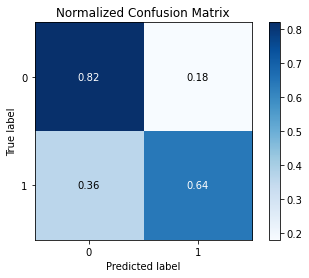

In [99]:
import scikitplot as skplt
import matplotlib.pylab as plt

skplt.metrics.plot_confusion_matrix(trueLabel, predLabel, normalize=True)
plt.show()

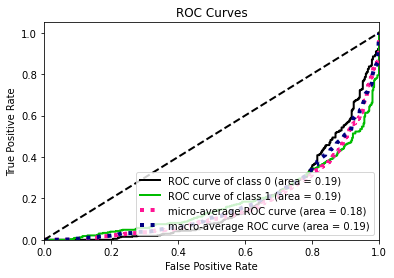

In [100]:
skplt.metrics.plot_roc(trueLabel, predProb)
plt.show()

## Predict and write file

#### For Pyspark

In [84]:
predictionTest = algorithm.fit(trainingDataPreprocessed).transform(testDataPreprocessed)

In [85]:
predLabelTest = np.array(predictionTest.select('prediction').collect()).squeeze()

#### For other algorithms

##### LightGBM

In [200]:
predictionTest = bst.predict(testPath, num_iteration=bst.best_iteration)

In [196]:
predLabelTest = np.array([1 if x >= 0.5 else 0 for x in predictionTest])

#### Upload to kaggle

In [ ]:
submission = pd.read_csv('nlp-getting-started/sample_submission.csv')
submission['target'] = submission['target'] + predLabelTest.astype(int)
submission.to_csv('submission.csv', index=False)

In [199]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "LightGbm"

100%|██████████████████████████████████████| 22.2k/22.2k [00:04<00:00, 4.63kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets